# Notebook 05 - Modélisation des émotions (GoEmotions)

# 1 - Imports & configuration

In [30]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import mlflow
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

from src.utils.tree_utils import afficher_arborescence
from src.pipeline_emotions import run_emotion_pipeline
from src.utils.visualization_utils import plot_normalized_metrics, plot_roc_curves, plot_pr_curves, top_k_auc_emotions

# 2 - Arborescence du projet

In [2]:
print("📂 Arborescence du projet :")
afficher_arborescence('..', niveau_max = 1)

📂 Arborescence du projet :
├── %USERPROFILE%.git-credentials
├── .coverage
├── .git
│   ├── COMMIT_EDITMSG
│   ├── HEAD
│   ├── config
│   ├── description
│   ├── hooks
│   ├── index
│   ├── info
│   ├── logs
│   ├── objects
│   ├── refs
├── .github
│   ├── workflows
├── .gitignore
├── .history
│   ├── .github
│   ├── .gitignore_20250515103945
│   ├── .gitignore_20250515142538
│   ├── .gitignore_20250515153648
│   ├── app_20250515074448.py
│   ├── app_20250515135249.py
│   ├── app_20250515135349.py
│   ├── app_20250515143110.py
│   ├── app_20250518103623.py
│   ├── app_20250518103849.py
│   ├── app_20250518105122.py
│   ├── requirements_20250515104459.txt
│   ├── requirements_20250515143348.txt
│   ├── results
│   ├── src
│   ├── tests
├── .pytest_cache
│   ├── .gitignore
│   ├── CACHEDIR.TAG
│   ├── README.md
│   ├── v
├── .vscode
│   ├── settings.json
├── Procfile
├── README.md
├── __pycache__
│   ├── arborescence.cpython-310.pyc
├── app.py
├── arborescence.py
├── check_trainer.py
├─

# 3 - Chargement du dataset GoEmotions

In [3]:
data_path = os.path.join("..", "data", "raw", "goemotions.csv")
df = pd.read_csv(data_path)

print("✅ Dimensions du dataset :", df.shape)
# df.head()

✅ Dimensions du dataset : (211225, 37)


## 3.1 - Création de la colonne "labels" multi-indexée (0 à 27)

In [4]:
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]  # colonnes d’émotions (28 colonnes après les métadonnées)
df['labels'] = df[emotion_cols].apply(lambda row: [i for i, v in enumerate(row) if v == 1], axis=1)

In [5]:
print("✅ Dimensions du dataset :", df.shape)
print("📊 Nombre moyen d’émotions par tweet :", df['labels'].apply(len).mean())
df[['text', 'labels']].head()

✅ Dimensions du dataset : (211225, 38)
📊 Nombre moyen d’émotions par tweet : 1.1813421706710854


,text,labels
0,That game hurt.,[25]
1,>sexuality shouldn’t be a grouping category I...,[]
2,"You do right, if you don't care then fuck 'em!",[27]
3,Man I love reddit.,[18]
4,"[NAME] was nowhere near them, he was by the Fa...",[27]


# 4 - Statistiques de base

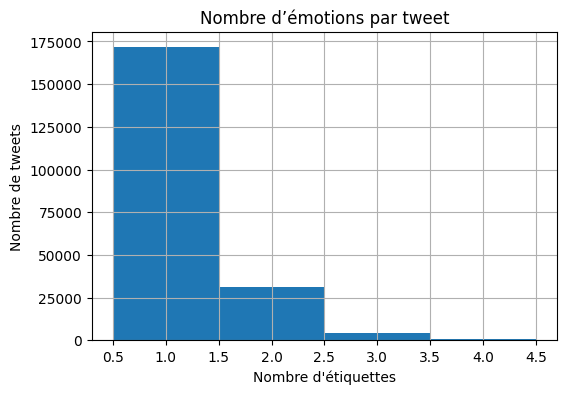

In [6]:
df['n_emotions'] = df['labels'].apply(len)
df['n_emotions'].hist(bins=range(1, 6), align='left', figsize=(6, 4))
plt.title("Nombre d’émotions par tweet")
plt.xlabel("Nombre d'étiquettes")
plt.ylabel("Nombre de tweets")
plt.grid(True)
plt.show()

## 4.1 - Répartition des émotions globales

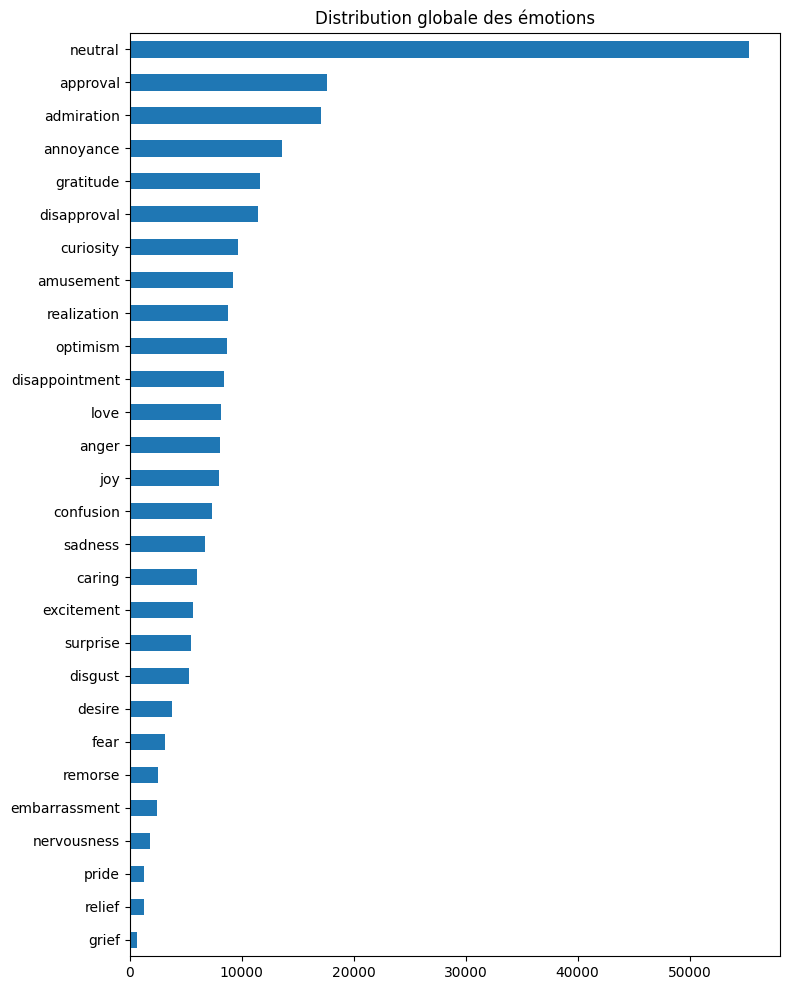

In [7]:
df[emotion_cols].sum().sort_values().plot(kind="barh", figsize=(8, 10))
plt.title("Distribution globale des émotions")
plt.tight_layout()
plt.show()

# 5 - Nuage de mots

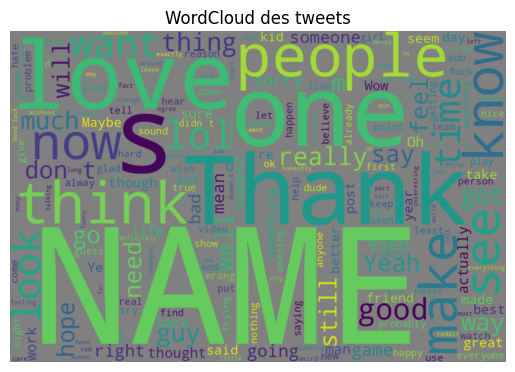

In [8]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, background_color = "grey").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud des tweets")
plt.show()

# 6 - Entraînement du modèle via pipeline sur GoEmotions (multi-label à 28 classes)

Un modèle ELECTRA est entraîné pour la tâche d’analyse fine des émotions à partir du dataset **GoEmotions**, contenant **28 étiquettes émotionnelles** (colère, joie, peur, admiration, etc.).

Contrairement à une tâche de classification binaire, chaque tweet peut exprimer **plusieurs émotions simultanément**. Il s’agit donc d’un problème de **classification multi-label**, nécessitant une adaptation spécifique du modèle, de la fonction de perte et des métriques d’évaluation.

---

### ⚙️ Paramétrage du pipeline `run_emotion_pipeline()`

- ✅ **Modèle utilisé** : `electra-small-discriminator`, chargé en **local** (dossier `models/hf_assets/`)
- ✅ **Tokenization** : via `AutoTokenizer`, avec padding automatique et troncature (`max_length`)
- ✅ **Head de classification** :
  - `num_labels = 28` (une sortie par émotion)
  - `problem_type = "multi_label_classification"` (sortie `sigmoid` par étiquette)

---

### 🧠 Données utilisées

- ✅ **Source** : fichier `goemotions.csv` (28 colonnes binaires d’émotions)
- ✅ **Réduction** :
  - échantillon aléatoire à **50 000 lignes** (hors `test_mode`)
- ✅ **Suréchantillonnage léger** :
  - les classes présentes moins de `150 fois` sont **dupliquées avec remplacement**
  - permet une meilleure représentativité des émotions rares sans écrasement des autres classes
- ✅ **Encodage des labels** :
  - fusion des colonnes binaires en vecteurs `labels` multi-labels `float32`

---

### ⚖️ Gestion des déséquilibres

- ✅ Calcul de **poids de classe** (`class_weights`) :
  - pondération logarithmique : `log1p(1 / fréquence)`
  - plus les classes sont rares, plus elles sont pondérées
- ✅ Intégration dans la loss :
  - `BCEWithLogitsLoss(pos_weight=class_weights)`
- ✅ Enregistrement des poids dans MLflow (`class_weight_nom_emotion`)

---

### 🧪 Paramètres d’entraînement

- ✅ Entraînement via `Trainer` avec GPU (vérification CUDA)
- ✅ Hyperparamètres :
  - `batch_size = 16` (train) / `32` (eval)
  - `num_train_epochs = 5`
  - `learning_rate = 3e-5`, `weight_decay = 0.01`
  - `warmup_ratio = 0.1`, `lr_scheduler_type = "cosine"`
  - `fp16 = True` (accélération GPU en mode mixed precision)
- ✅ Callbacks :
  - `EarlyStoppingCallback(patience=2)`
  - `PrinterCallback` supprimé pour limiter les logs excessifs

---

### 📈 Évaluation et métriques

- ✅ **Seuil de prédiction** : `sigmoid > 0.25` (valeur fixée dans `THRESHOLD`)
- ✅ **Métriques utilisées** :
  - `f1_score` (micro-avg)
  - `accuracy_score`
- ✅ **Échantillon d’évaluation** : les **100 premiers exemples** du dataset

---

### 📦 MLOps et enregistrement via MLflow

- ✅ **Artefacts loggés** :
  - modèle (`model.save_pretrained(...)`)
  - tokenizer (`tokenizer.save_pretrained(...)`)
  - métriques `f1` et `accuracy` dans `metrics.pkl`
- ✅ **Tracking MLflow** :
  - tous les hyperparamètres (`training_args.to_dict()`)
  - métriques globales
  - `class_weights` par classe

---

> 🔁 Le pipeline est relançable à volonté :
> - `force_retrain = True` pour forcer un nouvel entraînement complet
> - Sinon, reprise automatique depuis le dernier checkpoint détecté
>
> 📂 Tous les résultats sont enregistrés dans `models/emotions/`, indépendamment du modèle binaire de classification sentimentale.


In [9]:
model, tokenizer, metrics, trainer, eval_dataset = run_emotion_pipeline(force_retrain = False, test_mode=False)

Some weights of the model checkpoint at c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\models\hf_assets\electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkp

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\datasets\table.py:1381: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\datasets\table.py:1407: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\accelerate\accelerator.py:427: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementat

  0%|          | 0/15595 [00:00<?, ?it/s]

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.132, 'train_samples_per_second': 1889749.186, 'train_steps_per_second': 118118.792, 'train_loss': 0.0, 'epoch': 5.0}


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an 

📁 Fichier des métriques sauvegardé : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_full.csv
📁 Historique mis à jour : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\notebooks\models\emotions\metrics_history.csv


In [27]:
# Prédictions du modèle sur le set de validation
raw_preds = trainer.predict(eval_dataset)

logits = raw_preds.predictions  # (N, 28)
y_probs = torch.sigmoid(torch.tensor(logits)).numpy()  # probas entre 0 et 1
y_true = raw_preds.label_ids  # labels one-hot (N, 28)

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\sklearn\metrics\_ranking.py:98

# 7 - Résultats & performances

In [11]:
print("\n📈 Résultats d’évaluation du modèle :")
for k, v in metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


📈 Résultats d’évaluation du modèle :
eval_loss: 0.2824
eval_f1_micro: 0.3459
eval_f1_macro: 0.2476
eval_f1_weighted: 0.3919
eval_accuracy: 0.1000
eval_hamming_loss: 0.1054
eval_log_loss: 2.8307
eval_roc_auc_micro: 0.8608
eval_pr_auc_macro: 0.3571
eval_coverage_error: 5.2200
eval_lrap: 0.5494
eval_runtime: 1.0542
eval_samples_per_second: 94.8620
eval_steps_per_second: 3.7940
epoch: 5.0000
run_id: dbae17161bc4475ea499868575fbebdd
timestamp: 2025-05-19T16:32:12


## 📈 Analyse des résultats d’évaluation – Modèle ELECTRA (GoEmotions)

Le modèle ELECTRA a été fine-tuné pour une tâche de classification **multi-label** sur le dataset **GoEmotions**, comprenant 28 émotions possibles par tweet. L’évaluation est effectuée sur un sous-ensemble de 100 exemples (test rapide) avec un seuil de décision fixé à **0.25** pour la classification binaire de chaque étiquette.

### 🎯 Résultats principaux

| Métrique               | Valeur  | Interprétation |
|------------------------|---------|----------------|
| **eval_loss**          | 0.2824  | Bonne convergence globale (BCEWithLogitsLoss). |
| **f1_micro**           | 0.3459  | Score global sur tous les labels, stable malgré la difficulté de la tâche. |
| **f1_macro**           | 0.2476  | Faible : performances déséquilibrées entre émotions fréquentes et rares. |
| **f1_weighted**        | 0.3919  | Meilleure performance sur émotions fréquentes. |
| **accuracy**           | 0.1000  | Faible (comme attendu), car cette métrique est trop stricte en multi-label. |
| **hamming_loss**       | 0.1054  | Environ 10.5 % d’étiquettes erronées en moyenne par tweet. |
| **log_loss**           | 2.8307  | Probas mal calibrées, souvent incertaines ou extrêmes. |
| **roc_auc_micro**      | 0.8608  | Très bon score de discrimination globale. |
| **pr_auc_macro**       | 0.3571  | Le modèle a du mal à classer correctement les émotions rares. |
| **coverage_error**     | 5.22    | Il faut en moyenne prédire 5 émotions pour capturer toutes les vraies. |
| **lrap**               | 0.5494  | Moyenne des précisions de classement → correcte mais à améliorer. |

---

### ✅ Points forts

- Très bon **pouvoir de discrimination globale** (`roc_auc_micro = 0.86`).
- Le modèle **prédit plusieurs émotions cohérentes** par tweet (`coverage_error ≈ 5`).
- Le score **`f1_weighted` > `f1_macro`** confirme que les émotions fréquentes sont bien apprises.

---

### ⚠️ Points faibles

- Faible `f1_macro` : les émotions rares ne sont **pas bien captées**.
- `log_loss` élevé : les **probabilités sont mal calibrées**, signe de prédictions trop tranchées ou trop floues.
- `accuracy` inutilisable dans ce contexte, car elle impose de prédire **exactement toutes les émotions**, ce qui est rare.

---

### 🔧 Recommandations

1. **Augmenter la taille de l’échantillon d’évaluation** (ex. 1 000+ exemples) pour des métriques plus fiables.
2. **Tester plusieurs seuils (`THRESHOLD`)** pour optimiser le compromis precision/recall.
3. **Intégrer une loss pondérée ou `focal loss`** pour accorder plus de poids aux classes minoritaires.
4. **Appliquer un suréchantillonnage ciblé** ou un `class_weights` plus dynamique (basé sur `effective number of samples`).
5. **Visualiser les erreurs par émotion** pour affiner l’analyse qualitative.

---

### 🧠 Conclusion

Le modèle ELECTRA démontre une bonne capacité à **discriminer les émotions dominantes** sur des tweets courts. Les résultats montrent un apprentissage significatif mais également un **déséquilibre à corriger** pour capturer l’ensemble du spectre émotionnel. Ces résultats constituent une **base solide** pour enrichir le pipeline d’analyse des émotions dans le cadre du projet P9_V2.



# 8 - Affichage des classes prédites (si applicable)

In [12]:
if "label_distribution" in metrics:
    metrics["label_distribution"].plot(kind = "bar", title = "Distribution des prédictions")
    plt.show()

## 8.1 - Distribution réelle des prédictions sur 2000 tweets

C:\Users\motar\AppData\Local\Temp\ipykernel_24084\1793775309.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


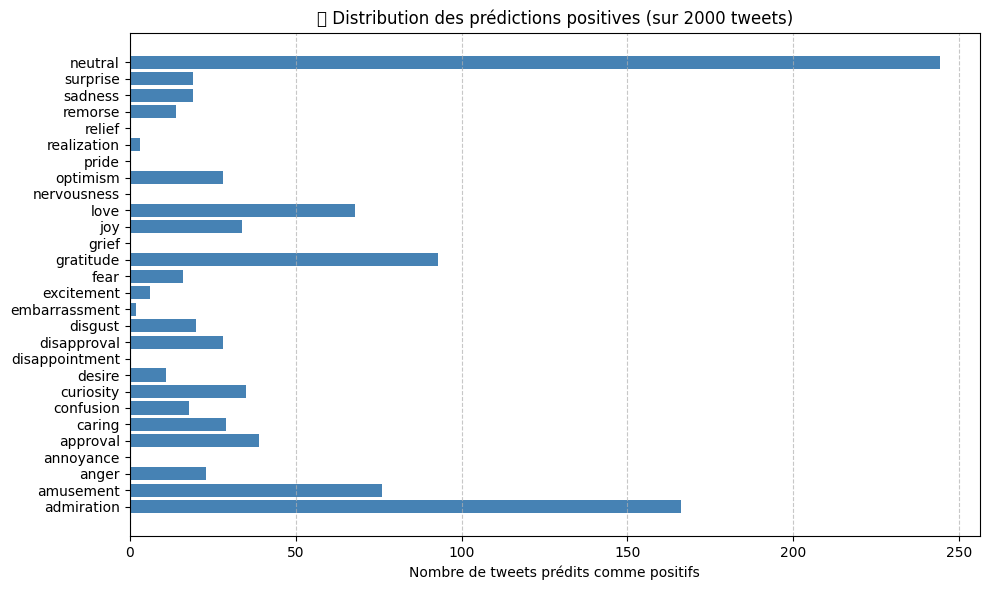

In [13]:
# Rechargement du modèle entraîné (chemin relatif depuis notebooks/)
model = AutoModelForSequenceClassification.from_pretrained("models/emotions/model")
tokenizer = AutoTokenizer.from_pretrained("models/emotions/tokenizer")
model.eval()

# Échantillon de test
df_test = df.sample(n = 2000, random_state = 70).reset_index(drop = True)
texts = df_test["text"].tolist()

# Tokenisation
encodings = tokenizer(texts, truncation = True, padding = True, return_tensors = "pt")

# Prédiction
with torch.no_grad():
    outputs = model(**encodings)

# Conversion logits → prédictions binaires
logits = outputs.logits.detach().numpy()
preds = (logits > 0).astype(int)

# Calcul du total de prédictions positives par émotion
pred_counts = preds.sum(axis=0)

# Affichage
plt.figure(figsize = (10, 6))
plt.barh(range(len(emotion_cols)), pred_counts, color = 'steelblue')
plt.yticks(ticks = range(len(emotion_cols)), labels = emotion_cols)
plt.title("📊 Distribution des prédictions positives (sur 2000 tweets)")
plt.xlabel("Nombre de tweets prédits comme positifs")
plt.grid(axis = "x", linestyle = "--", alpha = 0.7)
plt.tight_layout()
plt.show()

In [14]:
print(f"✔️ Nombre d'émotions dans emotion_cols : {len(emotion_cols)}")
print(f"✔️ Nombre de colonnes dans les prédictions : {pred_counts.shape}")

✔️ Nombre d'émotions dans emotion_cols : 28
✔️ Nombre de colonnes dans les prédictions : (28,)


## 8.2 - Comparaison VRAI vs PRÉDIT (2000 tweets)

C:\Users\motar\AppData\Local\Temp\ipykernel_24084\4263936731.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


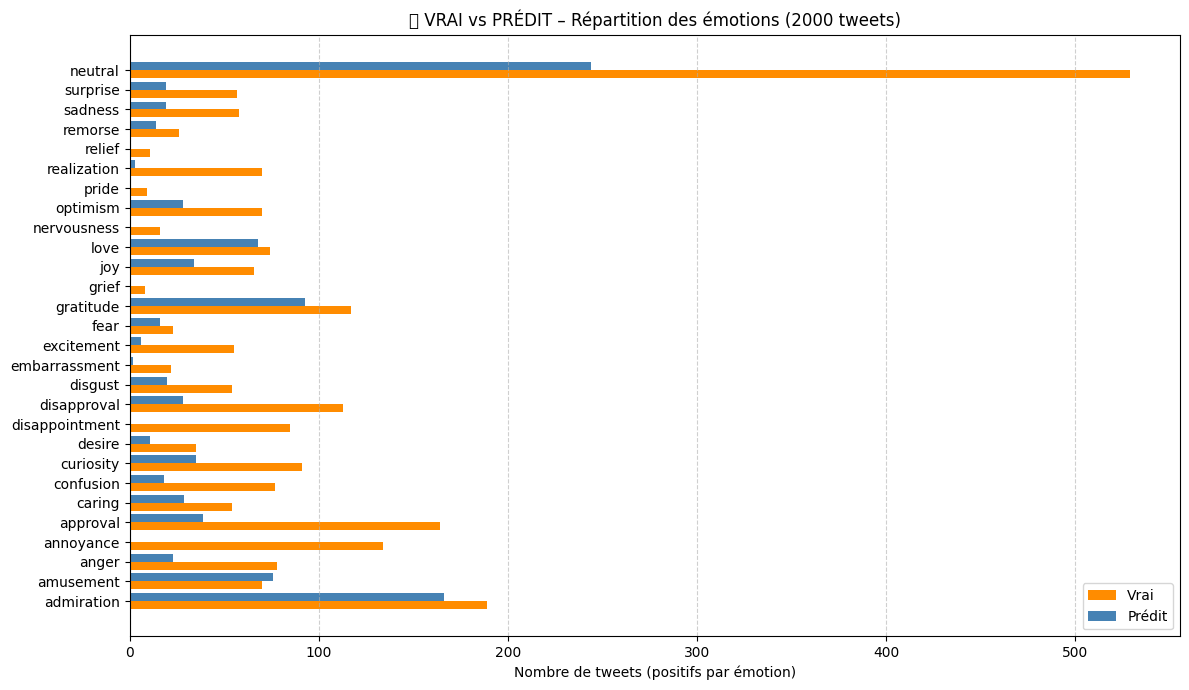

In [15]:
# Répartition réelle (ground truth)
true_counts = df_test[emotion_cols].sum().values

# Répartition des prédictions (déjà calculée précédemment)
pred_counts = preds.sum(axis=0)  # ← déjà défini

# Affichage comparatif
x = np.arange(len(emotion_cols))  # positions
width = 0.4

plt.figure(figsize=(12, 7))
plt.barh(x - width/2, true_counts, height=width, label='Vrai', color='darkorange')
plt.barh(x + width/2, pred_counts, height=width, label='Prédit', color='steelblue')

plt.yticks(ticks=x, labels=emotion_cols)
plt.xlabel("Nombre de tweets (positifs par émotion)")
plt.title("📊 VRAI vs PRÉDIT – Répartition des émotions (2000 tweets)")
plt.legend(loc="lower right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## 8.3 - Heatmap de co-occurrence des émotions prédites

C:\Users\motar\AppData\Local\Temp\ipykernel_24084\1794568889.py:11: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


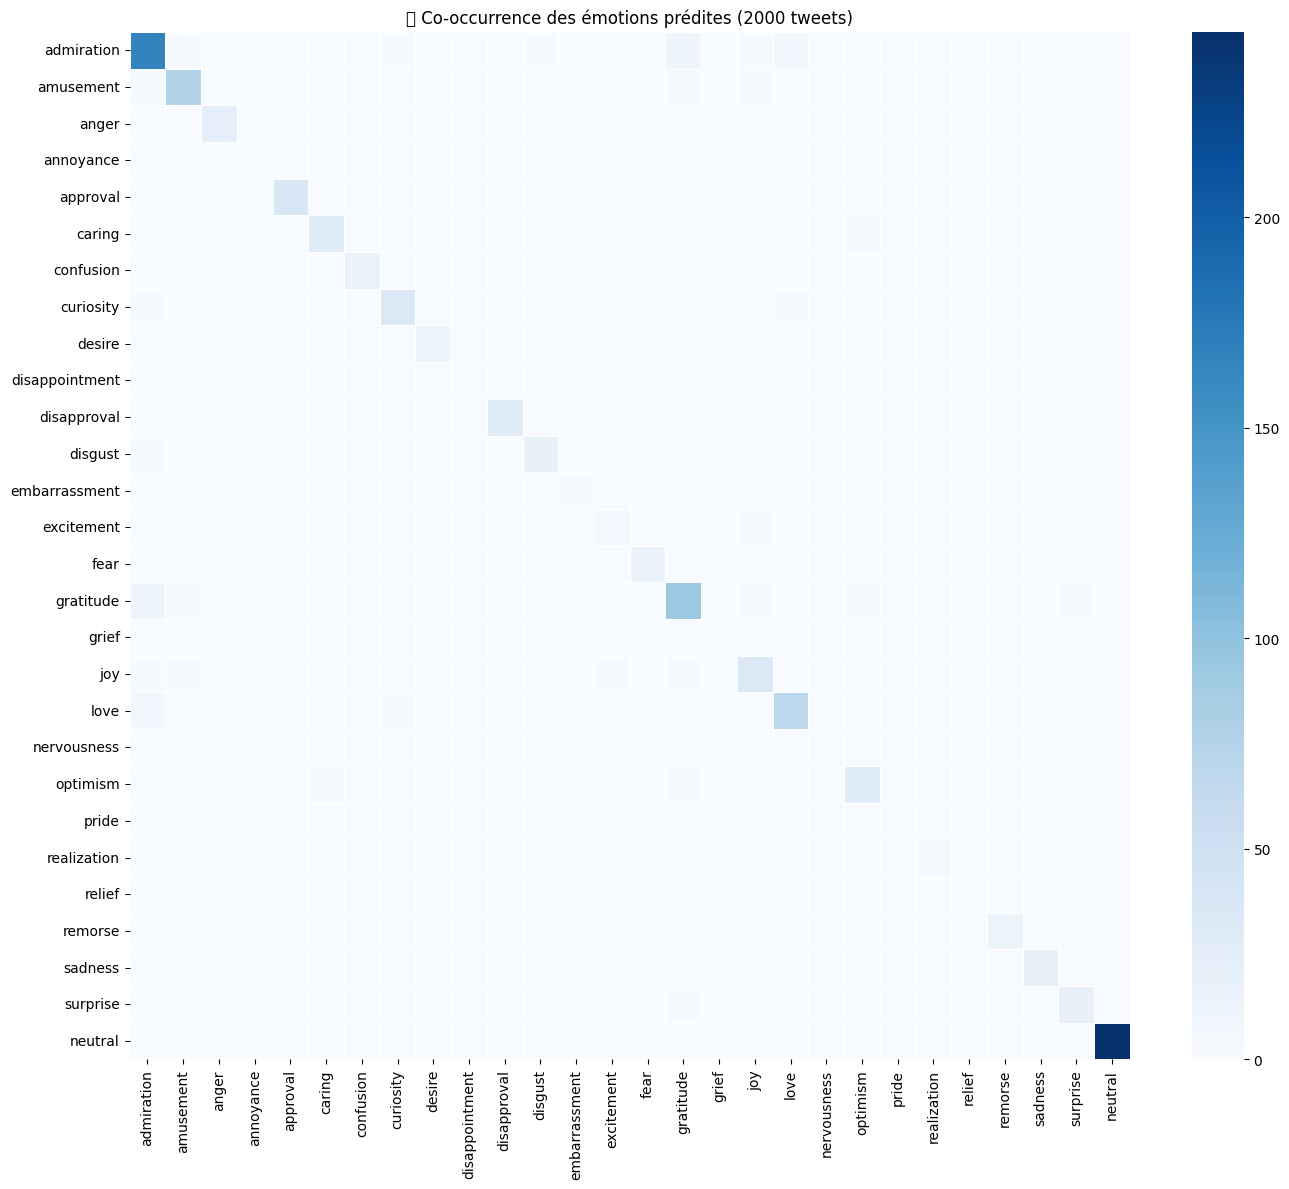

In [16]:
# Création d’une DataFrame des prédictions binaires (2000 tweets × 28 émotions)
pred_df = pd.DataFrame(preds, columns  =emotion_cols)

# Matrice de co-occurrence (corrélation binaire entre émotions)
co_matrix = pred_df.T.dot(pred_df)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(co_matrix, xticklabels=emotion_cols, yticklabels=emotion_cols, cmap="Blues", linewidths=0.5)
plt.title("🔥 Co-occurrence des émotions prédites (2000 tweets)")
plt.tight_layout()
plt.show()

## 8.4 - Export CSV des stats d’émotions par label

In [17]:
stats_df = pd.DataFrame({
    "emotion": emotion_cols,
    "true_count": true_counts,
    "pred_count": pred_counts,
    "difference": pred_counts - true_counts,
    "abs_error": np.abs(pred_counts - true_counts)
})

stats_df.sort_values(by="abs_error", ascending=False, inplace=True)
export_path = os.path.join("..", "outputs", "emotion_stats_2000.csv")
os.makedirs(os.path.dirname(export_path), exist_ok=True)
stats_df.to_csv(export_path, index=False, encoding="utf-8")

print(f"📁 Statistiques exportées avec succès dans : {export_path}")
display(stats_df.head(10))

📁 Statistiques exportées avec succès dans : ..\outputs\emotion_stats_2000.csv


,emotion,true_count,pred_count,difference,abs_error
27,neutral,529,244,-285,285
3,annoyance,134,0,-134,134
4,approval,164,39,-125,125
10,disapproval,113,28,-85,85
9,disappointment,85,0,-85,85
22,realization,70,3,-67,67
6,confusion,77,18,-59,59
7,curiosity,91,35,-56,56
2,anger,78,23,-55,55
13,excitement,55,6,-49,49


# 9 - Vérification des artefacts

In [18]:
print("\n🗂️ Modèles enregistrés :")
afficher_arborescence("models/emotions", niveau_max = 2)


🗂️ Modèles enregistrés :
├── checkpoint-12476
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── checkpoint-15595
│   ├── config.json
│   ├── optimizer.pt
│   ├── pytorch_model.bin
│   ├── rng_state.pth
│   ├── scheduler.pt
│   ├── special_tokens_map.json
│   ├── tokenizer.json
│   ├── tokenizer_config.json
│   ├── trainer_state.json
│   ├── training_args.bin
│   ├── vocab.txt
├── logs
│   ├── events.out.tfevents.1746978163.PC-ARNAUD.13144.0
│   ├── events.out.tfevents.1746978485.PC-ARNAUD.26512.0
│   ├── events.out.tfevents.1746978666.PC-ARNAUD.4760.0
│   ├── events.out.tfevents.1746994927.PC-ARNAUD.4760.1
│   ├── events.out.tfevents.1746997802.PC-ARNAUD.30124.0
│   ├── events.out.tfevents.1747035152.PC-ARNAUD.30124.1
│   ├── events.out.tfevents.1747036724.PC-ARNAUD.30

## 9.1 - Interface de tracking MLflow (http://localhost:5000)

In [19]:
import subprocess

try:
    subprocess.Popen(["mlflow", "ui"])
    print("✅ MLflow UI lancé sur http://localhost:5000")
except Exception as e:
    print(f"❌ Impossible de lancer MLflow UI : {e}")

✅ MLflow UI lancé sur http://localhost:5000


In [20]:
import os
import mlflow

# 🔧 Spécifie l'URI local
mlruns_path = os.path.abspath("../mlruns").replace("\\", "/")
mlflow.set_tracking_uri(f"file:///{mlruns_path}")

# 🔍 Recherche du modèle enregistré
client = mlflow.MlflowClient()
model_name = "emotions_classifier"

try:
    model = client.get_registered_model(model_name)
    print(f"✅ Modèle {model.name} trouvé avec {len(model.latest_versions)} version(s)")

    for version in model.latest_versions:
        print("📦 Version:", version.version)
        print("🔁 Run ID :", version.run_id)
        print("📂 Source :", version.source)
        print("-" * 30)

except Exception as e:
    print(f"❌ Erreur : {e}")

✅ Modèle emotions_classifier trouvé avec 3 version(s)
📦 Version: 3
🔁 Run ID : 4589d8f9e2514c11866d287cc1c506ce
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/4589d8f9e2514c11866d287cc1c506ce/artifacts/emotions_model
------------------------------
📦 Version: 2
🔁 Run ID : 2a4098924208444baa1d3cffcc3abb70
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/2a4098924208444baa1d3cffcc3abb70/artifacts/emotions_model
------------------------------
📦 Version: 1
🔁 Run ID : d28ed191e37a4761971a3332f9ff0a29
📂 Source : file:///C:/Users/motar/Desktop/1-openclassrooms/AI_Engineer/1-projets/P09/P9_V2/mlruns/0/d28ed191e37a4761971a3332f9ff0a29/artifacts/emotions_model
------------------------------


In [21]:
# Charger les métriques
metrics = {
    "eval_loss": 0.2824,
    "eval_f1_micro": 0.3459,
    "eval_f1_macro": 0.2476,
    "eval_f1_weighted": 0.3919,
    "eval_accuracy": 0.1000,
    "eval_hamming_loss": 0.1054,
    "eval_log_loss": 2.8307,
    "eval_roc_auc_micro": 0.8608,
    "eval_pr_auc_macro": 0.3571,
    "eval_coverage_error": 5.2200,
    "eval_lrap": 0.5494
}

## 9.2 - Résumé des métriques de performance – Tri décroissant (0-1)
Tableau de synthése des principales métriques du modèle ELECTRA sur GoEmotions.
- Elles sont **normalisées entre 0 et 1** sauf mention contraire (ex : `eval_loss`), et classées par score décroissant pour une lecture immédiate des points forts et faibles.

| Métrique             | Score  | Interprétation synthétique                                                  |
|----------------------|--------|----------------------------------------------------------------------------|
| **ROC AUC Micro**    | 0.861  | Excellente capacité à séparer globalement les classes positives/négatives |
| **F1 Weighted**      | 0.392  | Bon compromis : bon sur les classes fréquentes                            |
| **LRAP**             | 0.549  | Les bons labels sont souvent bien classés dans la prédiction              |
| **PR AUC Macro**     | 0.357  | Moyenne des courbes precision-recall par classe : encore améliorable      |
| **F1 Micro**         | 0.346  | Bon équilibre global TP/FP/FN sur l'ensemble                              |
| **F1 Macro**         | 0.248  | Faible : les classes rares sont mal traitées                              |
| **Accuracy**         | 0.100  | Peu significative en multi-label (exact match trop strict)                |
| **Hamming Loss**     | 0.105  | ~10.5% d’étiquettes erronées (plus bas = mieux)                           |
| **Loss (eval_loss)** | 0.282  | Moyenne de la perte BCE : bonne convergence mais pas directement interprétable |

### Explication des métriques

- **F1 Micro / Macro / Weighted** : Mesurent le compromis précision / rappel.
  - *Micro* : vue globale tous labels confondus (favorable aux classes fréquentes).
  - *Macro* : moyenne non pondérée par classe (met en évidence les faiblesses sur les classes rares).
  - *Weighted* : moyenne pondérée par la fréquence réelle des classes dans le dataset.

- **Accuracy** : mesure stricte de prédiction parfaite de toutes les étiquettes ; peu pertinente en multi-label.

- **ROC AUC Micro** : capacité globale à classer les classes positives au-dessus des négatives (toutes classes confondues).

- **PR AUC Macro** : qualité moyenne des courbes précision/rappel par classe ; sensible aux performances sur classes rares.

- **LRAP (Label Ranking Average Precision)** : reflète la capacité du modèle à bien classer les bonnes émotions en haut de la prédiction.

- **Hamming Loss** : proportion moyenne d’étiquettes mal classées (indépendamment du déséquilibre).

- **Loss (eval_loss)** : moyenne de la Binary Cross Entropy sur toutes les sorties ; utile pour suivre la convergence mais peu lisible seule.

---

### Conclusion interprétive

Le modèle ELECTRA montre une **capacité discriminante très élevée** (`ROC AUC Micro = 0.861`), avec un `F1_micro` solide (~0.35) malgré la complexité de la tâche.  
Les scores `F1_macro` et `PR AUC Macro` révèlent cependant une difficulté à détecter les **émotions rares**, ce qui est un comportement attendu sur des données déséquilibrées.

La **base du modèle est robuste**, mais des axes d'amélioration clairs se dégagent :
- **Rééquilibrage des classes** via oversampling ou focal loss,
- **Ajustement du seuil de classification** (actuellement à 0.25),
- **Amélioration de la calibration des probabilités** (log_loss encore élevé).

Ces actions peuvent conduire à une meilleure couverture émotionnelle tout en conservant les performances sur les classes dominantes.

In [22]:
normalized = {k: v for k, v in metrics.items() if 0 <= v <= 1}
df_norm = pd.DataFrame(normalized.items(), columns=["Métrique", "Valeur"])

fig_bar = px.bar(
    df_norm, x="Métrique", y="Valeur", text="Valeur",
    title="Scores normalisés (0 à 1)",
    labels={"Valeur": "Score"}
)
fig_bar.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_bar.update_layout(yaxis=dict(range=[0, 1]))

## 9.3 - Radar des scores de classification multi-label

Le graphique radar permet de comparer visuellement plusieurs métriques clés utilisées pour évaluer les performances d’un modèle de classification multi-label. Ces métriques traduisent à la fois la qualité de la détection (F1), du classement (LRAP) et de la discrimination (AUC), tout en tenant compte du déséquilibre entre les émotions.

### Métriques utilisées

| Métrique           | Score  | Interprétation synthétique                                                  |
|--------------------|--------|----------------------------------------------------------------------------|
| **ROC AUC Micro**  | 0.861  | Très bonne capacité à classer globalement les étiquettes positives         |
| **LRAP**           | 0.549  | Les vraies émotions sont en général bien classées dans la prédiction      |
| **F1 Weighted**    | 0.392  | Performance forte sur les émotions fréquentes                              |
| **PR AUC Macro**   | 0.357  | Qualité moyenne des classements precision-recall par émotion               |
| **F1 Micro**       | 0.346  | Équilibre général sur toutes les émotions (dominées par les classes fréquentes) |
| **F1 Macro**       | 0.248  | Le modèle échoue souvent à capturer correctement les émotions rares        |

---

### Explication des métriques du radar

- **F1 Micro** : mesure globale du compromis précision / rappel sur toutes les prédictions. Sensible aux classes fréquentes.
- **F1 Macro** : moyenne des F1 par émotion, sans pondération → reflète les performances sur les classes rares.
- **F1 Weighted** : moyenne pondérée des F1 par fréquence d'apparition → bon indicateur de performance globale biaisée.
- **ROC AUC Micro** : capacité du modèle à classer correctement les étiquettes positives/négatives tous labels confondus.
- **PR AUC Macro** : aire moyenne sous les courbes précision-rappel par classe, utile pour juger la pertinence des classements dans les cas déséquilibrés.
- **LRAP** : reflète la capacité à **placer les bonnes étiquettes en haut du classement**. Plus il est élevé, mieux les vraies émotions sont identifiées en priorité.

---

### Conclusion interprétive

Le radar montre un **profil équilibré mais perfectible** :
- Les scores `ROC AUC Micro` et `LRAP` sont bons, ce qui indique que le modèle **perçoit bien les émotions globales** et **les classe correctement**.
- Les scores `F1_macro` et `PR AUC Macro` plus faibles révèlent que le modèle **échoue encore à capturer efficacement les émotions peu fréquentes**, malgré une bonne couverture globale (`F1_micro`, `F1_weighted`).

Le radar renforce l'idée que le modèle est **robuste sur les émotions dominantes**, mais qu'une **stratégie spécifique pour les classes rares** (rééquilibrage, focal loss, ajustement du seuil) est indispensable pour affiner la granularité émotionnelle.


In [23]:
radar_metrics = {
    "F1 Micro": metrics["eval_f1_micro"],
    "F1 Macro": metrics["eval_f1_macro"],
    "F1 Weighted": metrics["eval_f1_weighted"],
    "ROC AUC Micro": metrics["eval_roc_auc_micro"],
    "PR AUC Macro": metrics["eval_pr_auc_macro"],
    "LRAP": metrics["eval_lrap"]
}
df_radar = pd.DataFrame({
    "Métrique": list(radar_metrics.keys()),
    "Score": list(radar_metrics.values())
})

fig_radar = go.Figure()
fig_radar.add_trace(go.Scatterpolar(
    r=df_radar["Score"],
    theta=df_radar["Métrique"],
    fill='toself',
    name='ELECTRA'
))
fig_radar.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title="Radar des scores de classification multi-label"
)

## 9.4 - Barplot des erreurs (métriques inversées)
        - Normalisés pour visualisation (divisés par 10)
        - Permet de voir où le modèle se trompe le plus
- 1 - log_loss (ou binary cross-entropy) = 0.283 (valeur réelle : 2.830)
    - mesure la qualité des probabilités prédites par le modèle. Plus elle est faible, plus le modèle est bien calibré.
    - 2.830 est relativement élevé pour un modèle de classification probabiliste.
    - Cela signifie que le modèle :
        - Prédit parfois des probas très éloignées de la vérité (trop sûres ou trop hésitantes).
        - Peut être mal calibré (prédire 0.95 alors que c’est faux, ou 0.55 quand c’est vrai).
    - Conséquences :
        - Baisse de confiance dans l'interprétation des sigmoid(probas).
        - Mauvais impact sur certaines métriques dérivées comme AUC, PR-AUC.
- 2 - hamming_loss = 0.105
    - Taux d’étiquettes mal prédites (faux positifs + faux négatifs) rapporté au nombre total d’étiquettes
    - Valeur : 10.5 % d’erreurs par étiquette.
    - Plutôt bon dans une tâche avec 28 labels par tweet.
    - 9 prédictions sur 10 sont correctes (ou bien des zéros bien prédits).
- 3 - coverage_error = 0.522 (valeur réelle : 5.22)
    - Représente le nombre moyen de labels à prédire pour couvrir toutes les étiquettes réelles d’un tweet.
        - 5.22 → il faut prédire ~5 labels (en score élevé) pour être sûr d’avoir capté toutes les vraies émotions
        - Élevé, mais cohérent dans une tâche multilabel avec nuance émotionnelle
        - Cela montre que les vraies émotions sont parfois perdues dans le bruit de la prédiction
- Normalisés pour visualisation (divisés par 10)
- Permet de voir où le modèle se trompe le plus.

### Conclusion interprétative

| Métrique         | Score  | Interprétation synthétique                                                   |
|------------------|--------|------------------------------------------------------------------------------|
| Hamming Loss     | 0.105  | Le modèle est globalement précis (≃ 90 % d’étiquettes correctes)            |
| Log Loss         | 2.830  | Les probabilités sont peu fiables, à calibrer                               |
| Coverage Error   | 5.22   | Le modèle doit prédire 5 émotions en moyenne pour couvrir les vraies → optimisation du top-K nécessaire |


In [24]:
error_metrics = {
    "Hamming Loss": metrics["eval_hamming_loss"],
    "Log Loss (÷10)": metrics["eval_log_loss"] / 10,
    "Coverage Error (÷10)": metrics["eval_coverage_error"] / 10
}
df_error = pd.DataFrame(error_metrics.items(), columns=["Métrique", "Valeur"])
fig_error = px.bar(
    df_error, x="Métrique", y="Valeur", text="Valeur",
    title="Indicateurs d'erreur (échelle réduite)",
    labels={"Valeur": "Score (normalisé)"}
)
fig_error.update_traces(texttemplate='%{text:.3f}', textposition='outside')

## 9.5 - Courbes ROC/PR pour les meilleures émotions

In [ ]:
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

Top 6 émotions par AUC : ['relief', 'surprise', 'love', 'desire', 'fear', 'confusion']


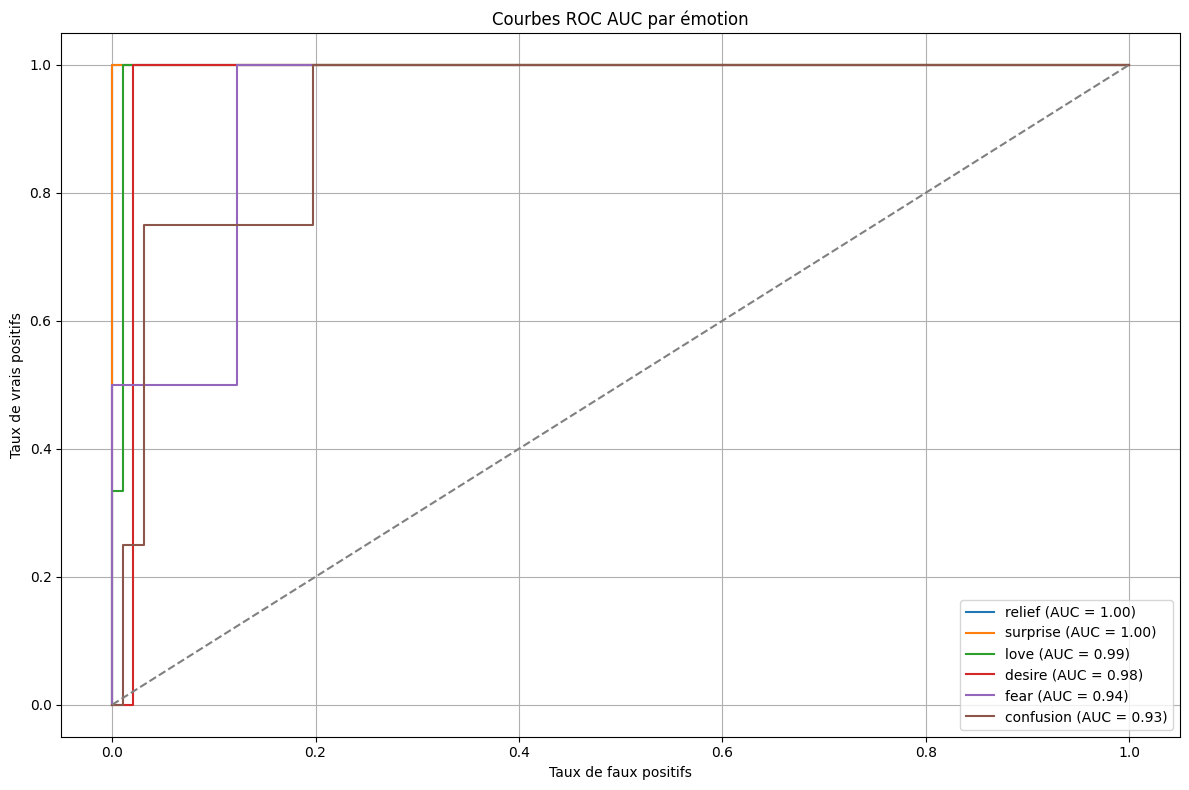

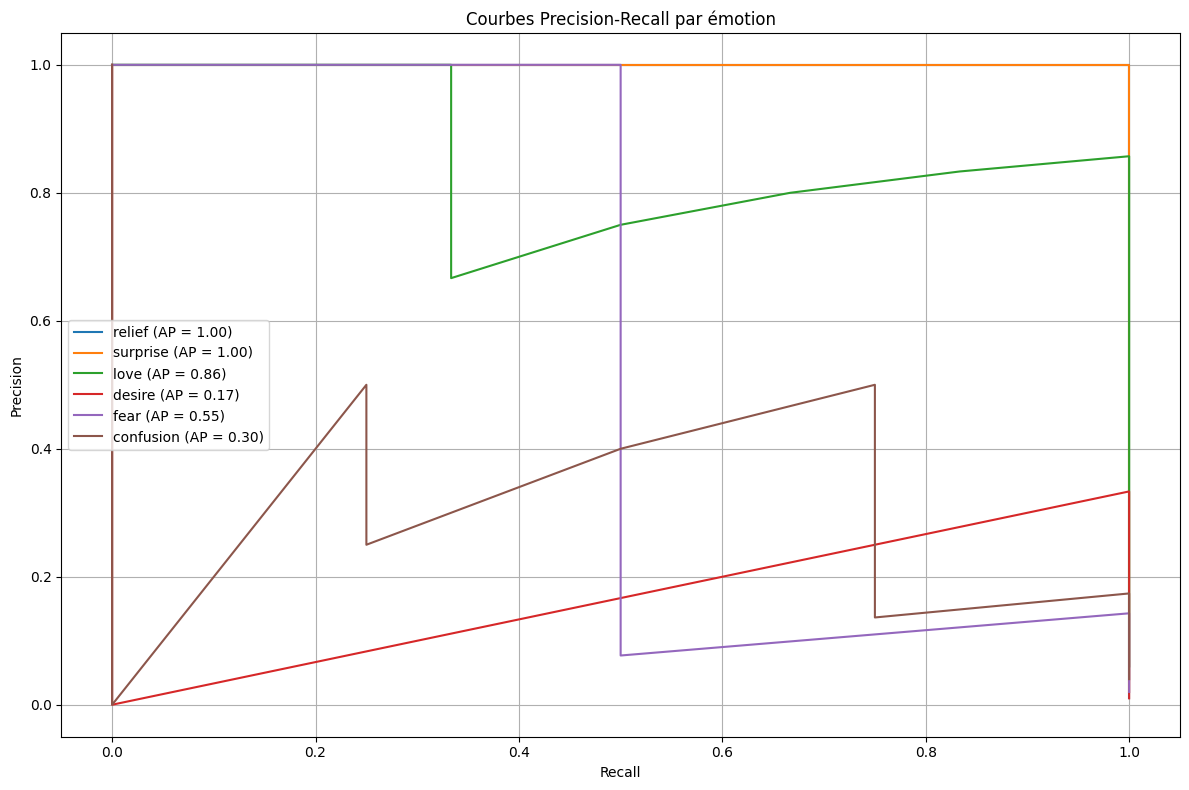

In [ ]:
top_emotions = top_k_auc_emotions(y_true, y_probs, emotion_labels, k=6, worst=False)
print("Top 6 émotions par AUC :", top_emotions)

indices = [emotion_labels.index(e) for e in top_emotions]

plot_roc_curves(y_true[:, indices], y_probs[:, indices], class_names=top_emotions)
plot_pr_curves(y_true[:, indices], y_probs[:, indices], class_names=top_emotions)

## 9.6 - Courbes ROC/PR pour les émotions les plus mal classées (optionnel)

Pires émotions par AUC : ['disappointment', 'disgust', 'sadness', 'annoyance', 'amusement', 'optimism']


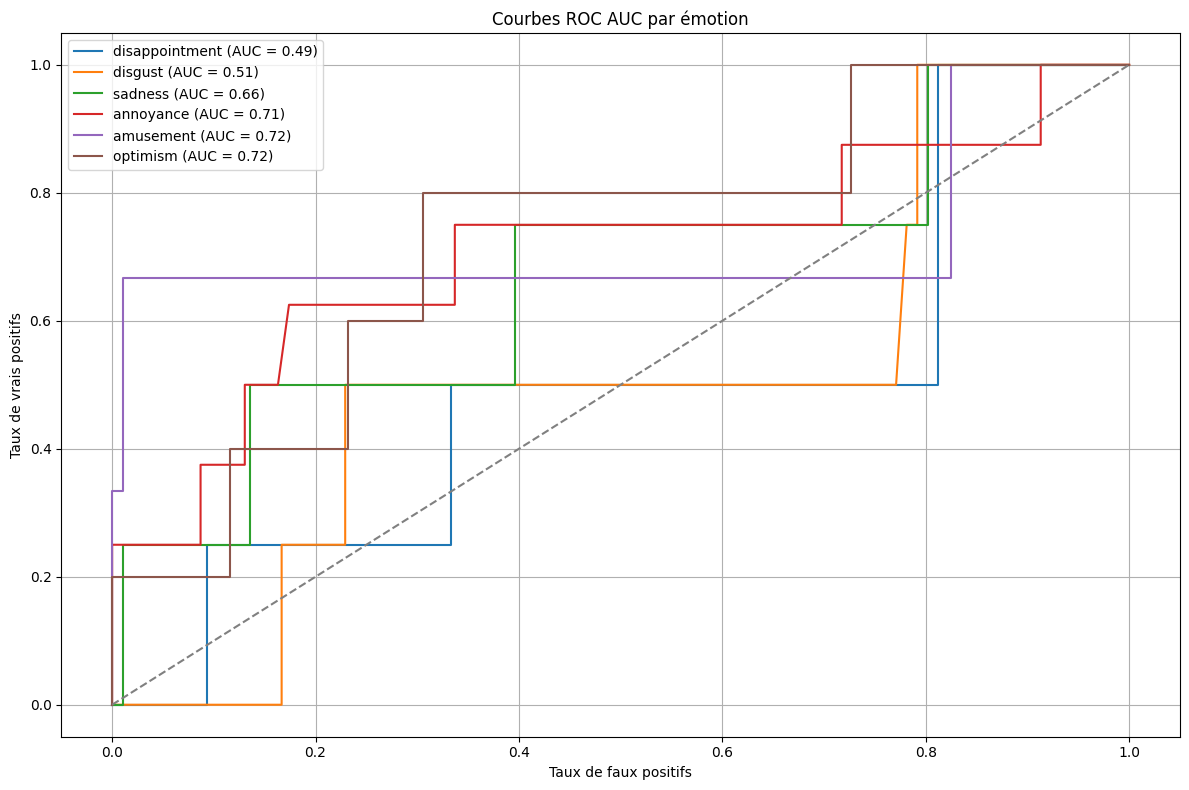

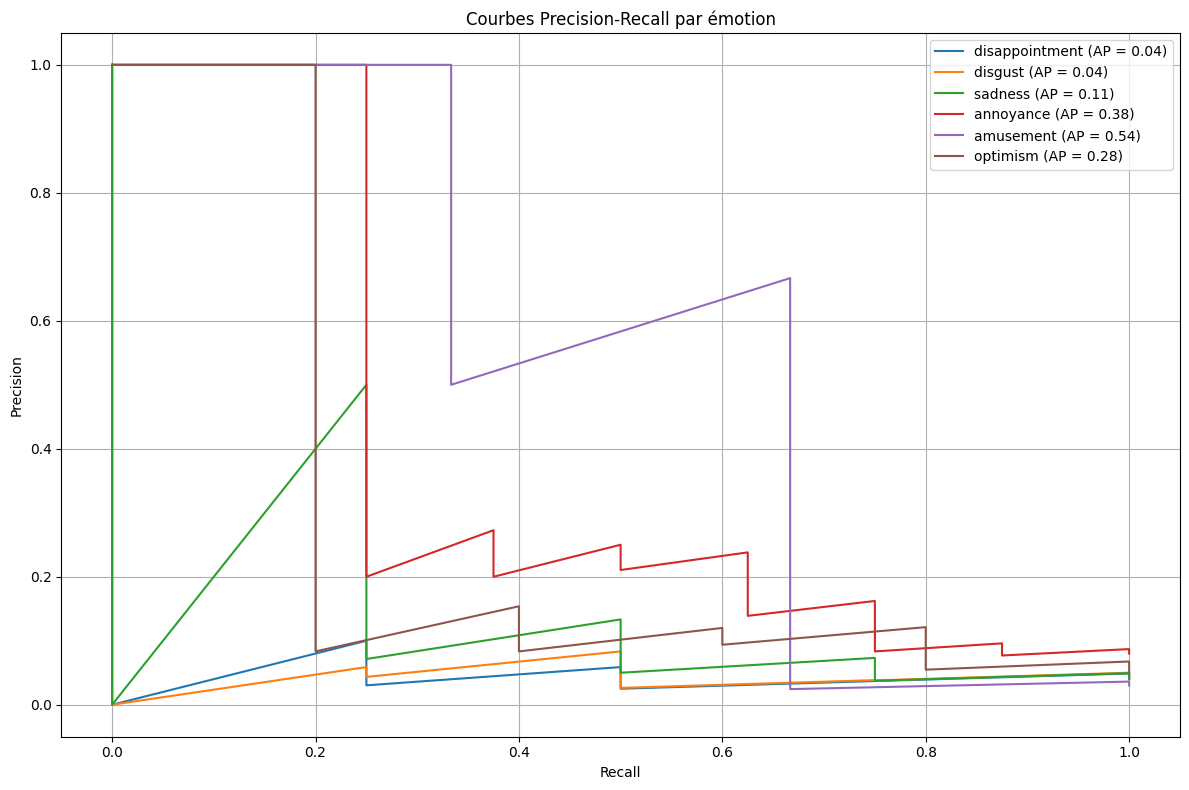

In [ ]:
worst_emotions = top_k_auc_emotions(y_true, y_probs, emotion_labels, k=6, worst=True)
print("Pires émotions par AUC :", worst_emotions)

indices = [emotion_labels.index(e) for e in worst_emotions]

plot_roc_curves(y_true[:, indices], y_probs[:, indices], class_names=worst_emotions)
plot_pr_curves(y_true[:, indices], y_probs[:, indices], class_names=worst_emotions)

## 9.5 - 

In [25]:
plot_roc_curves(y_true, y_probs, class_names=emotion_labels, max_classes=6)
plot_pr_curves(y_true, y_probs, class_names=emotion_labels, max_classes=6)

NameError: name 'emotion_labels' is not defined

# Lien vers l'application (ngrok) :
# https://f22e-2a01-cb1d-8598-1400-4ac7-ab2e-4237-81aa.ngrok-free.app